## Chapter 4: Introduction to statistical inference
(Linkedin learning : Springboard: Lesson 11.1)
  link:  linkedin.com/learning/python-statistics-essential-training/install-anaconda-python-on-os-x?u=36492188

In [1]:
import math
import io
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import scipy.spatial

In [2]:
poll = pd.read_csv('C:\\Projects\\Data Camp\Chapter 4 linkedin Satatistical inference\\Exercise Files\\chapter4\\04_02\\poll.csv')
pop = pd.read_csv('C:\\Projects\\Data Camp\\Chapter 4 linkedin Satatistical inference\\Exercise Files\\chapter4\\04_03\\grades.csv')
cholera = pd.read_csv('C:\\Projects\\Data Camp\\Chapter 4 linkedin Satatistical inference\\Exercise Files\\chapter4\\04_04\\cholera.csv')
pumps = pd.read_csv('C:\\Projects\\Data Camp\\Chapter 4 linkedin Satatistical inference\\Exercise Files\\chapter4\\04_04\\pumps.csv')
largepoll = pd.read_csv('C:\\Projects\\Data Camp\\Chapter 4 linkedin Satatistical inference\\Exercise Files\\chapter4\\04_05\\poll-larger.csv')


### 4.2 Linkedin learning: Confidence Intervel

In [463]:
poll.head()

,vote
0,Brown
1,Green
2,Brown
3,Brown
4,Brown


In [464]:
poll.vote.value_counts(normalize=True)

Brown    0.511
Green    0.489
Name: vote, dtype: float64

In [465]:
np.random.rand(5) < 0.51

array([ True,  True,  True,  True, False])

In [466]:
# re-arrage boolean value to string
np.where(np.random.rand(5) < 0.51, 'Brown', 'green')

array(['green', 'Brown', 'Brown', 'Brown', 'green'], dtype='<U5')

In [467]:
#we wrap everything in a DataFrame and make a function out of it. 
#I replace the number of poll voters in the Brown fraction by the arguments of the function.
def sample(brown, n=1000):
    return pd.DataFrame({'vote': np.where(np.random.rand(n) < brown, 'Brown', 'green')})

In [468]:
s = sample(0.51, n=1000)

In [469]:
s.vote.value_counts(normalize=True)

Brown    0.516
green    0.484
Name: vote, dtype: float64

In [470]:
# Let's see one possible sample, and the counts for the two candidates.
# In this case, Brown is actually under the level of winning the election, although is True fraction is .51. So we repeat this many times and collect the results in the DataFrame.
# 1,000 simulated experiments should be sufficient

dist = pd.DataFrame([sample(0.51).vote.value_counts(normalize=True) for i in range(1000)])
dist.head()

,Brown,green
vote,0.558,0.442
vote,0.496,0.504
vote,0.520,0.480
vote,0.526,0.474
vote,0.491,0.509


<AxesSubplot:>

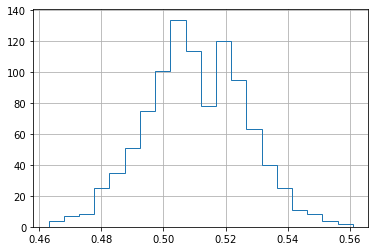

In [471]:
# let's look at the histogram. It turns out that for a True Brown fraction of .51,
# we may obtain any sample proportion from .48 to .55.

dist.Brown.hist(histtype = 'step', bins=20)

In [472]:
# simulate the sampling distribution for any True Brown fraction. 
# So let's make a function for that. I'll take code from above and replace the Brown fraction.

def samplingdist(brown, n=1000):
    
    return pd.DataFrame([sample(brown, n).vote.value_counts(normalize=True) for i in range(1000)])

In [473]:
# Let's say we want to go for the 95% confidence interval. 
# This will lie between the 2.5% quantile and the 97.5% quantile.
def quantiles(brown, n=1000):
    dist = samplingdist(brown, n)
    return dist.Brown.quantile(0.025), dist.Brown.quantile(0.975)

#### note:
So we look for the True fraction for which a measured value of .51 lies at a 2.5% quantile, and the True fraction for which our measured value lies at the 97.5 quantile. It turns out that those two fractions are the edges of the confidence interval. If you think about many different experiments where we repeat this procedure, you can convince yourself that this is indeed the case. So I'll make a function that extracts those quantiles by first calling samplinglist and then calling DataFrame quantile on it.

In [474]:
quantiles(0.5)

(0.469, 0.53)

In [475]:
quantiles(0.48)

(0.449, 0.5100250000000001)

In [476]:
quantiles(0.54)

(0.5079750000000001, 0.569)

#### note:
when the sample size is 1,000, the 95 confidence interval for the True population function is .48 to .54. We can also express the same by saying that our point estimate is .51, and that the margin of error is .03 on either side in 95% confidence. 

The margin of error is now more like 1%, which would have been sufficient to claim Brown as the likely winner. Under very general conditions, one can show that the margin of error improves with square root of the number of samples. But we actually have to collect the sample. You do so by stating it. Luckily, I'm giving you the file. And we find out that the likely winner is, in fact, Mrs. Green. If we were to compute the confidence interval for the Green fraction in this case, as we did above, we'd find that it is between .508 and .528. It doesn't include the threshold of .50. So now, you can go and write your article.

In [477]:
dist = samplingdist(0.5, 10000)

<AxesSubplot:>

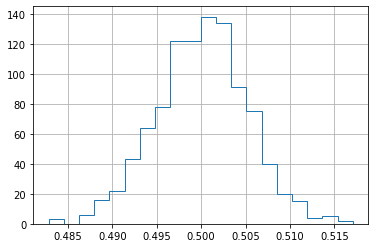

In [478]:
dist.Brown.hist(histtype = 'step', bins=20)

In [479]:
largepoll.vote.value_counts(normalize=True)

Green    0.5181
Brown    0.4819
Name: vote, dtype: float64

## Chapter 4.3 Bootstrapping

#### Note:
take only 100 samples. Then we import packages, and load the data. It seems the citizens gave you the grades with great precision. We're wrong with this

In [480]:
pop.head()

,grade
0,3.648651
1,5.959915
2,7.387370
3,4.047515
4,2.846912


In [481]:
poll.vote.value_counts()

Brown    511
Green    489
Name: vote, dtype: int64

<AxesSubplot:>

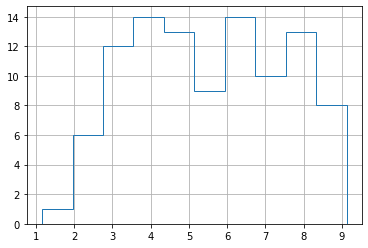

In [482]:
pop.grade.hist(histtype = 'step')

In [483]:
pop.describe()

,grade
count,100.000000
mean,5.508561
std,1.984988
min,1.160899
25%,3.921372
50%,5.688527
75%,7.272162
max,9.120705


#### 
So we look at the histogram, and this cribda sample with summary statistics.
The histogram has no recognizable simple form, but the mean for the sample is 5.5. What can we say about the true mean value? This time we cannot build a confidence interval by simulating the sampling distribution because we do not know how to describe it. And, indeed, given the observed histogram it is unlikely that it has a simple form such as a no amount distribution. However, we can still use computing by adopting a powerful idea in modern statistics, bootstrapping, which was introduced by Efron in 1979.

#### Note:
What we'll do is to estimate the uncertainty of our statistic, the mean, by generating a large family of samples from the one we have. And then, characterizing the distribution of the mean over this family. Each sample in the family is prepared as follow: we draw grades randomly for our single existing sample allowing the same grade to be drawn more than once. Technically speaking, we are sampling with replacement. Let's try to do it once.


In [484]:
pop.sample(100, replace=True).describe()

,grade
count,100.000000
mean,5.608665
std,1.857081
min,1.983167
25%,4.047515
50%,5.754333
75%,7.467589
max,8.522332


#### Note:
There are 11 pandas method is sample over 100 from dataframe pop with replacement. We see that for this bootstrapped sample the mean is a little difference. So let's build the bootstrapped distribution of means. We generate a bootstrap sample take the mean repeat this 1000 times using a Python list comprehension. And then fold this into a dataframe. We'll call the variable mean grade. And save everything into dataframe bootstrap. 

In [485]:
bootstrap = pd.DataFrame({'meangrade': [pop.sample(100,replace=True).grade.mean() for i in range(1000)]})

#### Note:
Let's take a histogram. Remember, these are not grades, but they are means of grades. Let me show you the original mean drawn as a line on top of this. The mean is actually the same, instead of our sample, if you think about it, it has to be. But there is significant spread around it. So let me extract the quantiles. That's it, bootstrap approximated, 95% confidence interval for the mean grade. It is between 5.1 and 5.9

<AxesSubplot:>

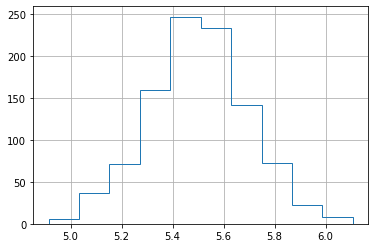

In [486]:
bootstrap.meangrade.hist(histtype = 'step')

In [487]:
bootstrap.meangrade.quantile(0.025), bootstrap.meangrade.quantile(0.975)

(5.124647909225822, 5.881324647359523)

#### 
It seems that the mean grade is likely to be a passing one. The bootstrap procedure requires that the sample you have is representative. And the procedure is justified by a rather complex mathematics, and the rather general assumptions. For the skies I will show you that the guess is acceptable by showing you how I really generated the data set. The distribution that I used was actually a sum of two normal distributions with equal weights. 

#### Note:
We can use side by stats to handle and play with distributions. If you don't know much about the normal distributions, just follow along qualitatively. I will plot this between 0 and 10. For a side by stats distribution object, PDF, returns the probability density. Here we go, this is a bimodal distribution.

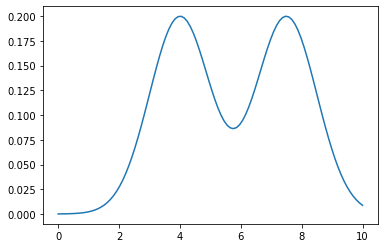

In [488]:
n1 = scipy.stats.norm(7.5, 1)
n2 = scipy.stats.norm(4, 1)

x = np.linspace(0, 10, 100)
plt.plot(x, 0.5*n1.pdf(x) + 0.5*n2.pdf(x))

#### Note:
I also truncated this distribution, because there can't be grades below 0 or above 10. So I made a function to drop a simple grade. I have yes for a side by stats distribution object just so it turns a random sample from that distribution. And I also need to choose between the two, which I do just by drawing a uniform distributing number between 0 and 1, and comparing it with .5. Then I truncate. So I continue drawing until I get a sample that's acceptable. 

Let's try it once. And now I can make a data set by calling this repeatedly.

In [489]:
def draw():
    while True:
        v = n1.rvs() if np.random.rand() < 0.5 else n2.rvs()
        if 0 <= v <= 10:
            return v
    

In [490]:
draw()

8.274815523613018

In [491]:
def dataset(n=100):
    return pd.DataFrame({'grade': [draw() for i in range(n)]})


#### Note:
Let's histogram a few of these samples. We select the column grade, we do histogram. And as for the sampling distribution of the mean, we can use simulation in a straightforward way. Let's look at the histogram and compare with the bootstrapped distribution. We see that the 2 sampling distribution is displaced on the bootstrap estimate, but the spreads are comparable, which justifies our approximated confidence interval.

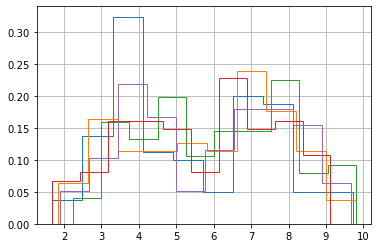

In [492]:
for i in range(5):
    dataset(100).grade.hist(histtype = 'step', density=True)

In [493]:
means = pd.DataFrame({'meangrade': [dataset(100).grade.mean() for i in range(1000)]})

<AxesSubplot:>

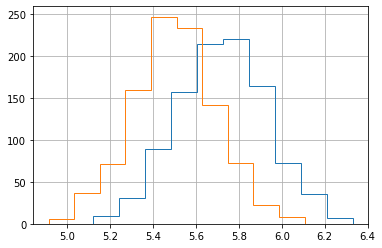

In [494]:
means.meangrade.hist(histtype = 'step')
bootstrap.meangrade.hist(histtype = 'step')



.





## Chapter 4.4  Hypothesis testing

we leave local covenants and we go back to 1854 in London, a very rough time because of the repeated and deadly epidemics of cholera. Physician John Snow used simple statistics and beautiful plotting, to pinpoint the origin of one such outbreak to a contaminated water pump on Broad Street. It's a fascinating story, go look it up. We are going to follow in John Snow's footsteps to learn about testing hypotheses. So here are two datasets. Let me first import packages. The first dataset contains the positions of eight water pumps in Central London

In [495]:
pumps.head()

,lat,lon,x,y
0,51.513341,-0.136668,0.000000,0.000000
1,51.513876,-0.139586,-0.201858,0.059469
2,51.514906,-0.139671,-0.207738,0.173961
3,51.512354,-0.131630,0.348513,-0.109712
4,51.512139,-0.133594,0.212650,-0.133611


####  
These are given as latitude/longitude, and also distances from a reference point, pump number zero, in kilometers. The other dataset contains the number of deaths at different locations, as well as the closest pump to that location. Let's look at one record every 20. We can plot this quickly. We want the square figure, and a scatter plot of the pumps, and the deaths. And we'll make these a little smaller. In fact, it would be fun to over-plot this on a map of London

In [496]:
cholera.head(20)

,deaths,lat,lon,x,y,closest
0,3,51.513418,-0.137930,-0.087301,0.008559,0
1,2,51.513361,-0.137883,-0.084050,0.002223,0
2,1,51.513317,-0.137853,-0.081975,-0.002668,0
3,1,51.513262,-0.137812,-0.079138,-0.008781,0
4,4,51.513204,-0.137767,-0.076025,-0.015229,0
5,2,51.513184,-0.137537,-0.060115,-0.017452,0
6,2,51.513359,-0.138200,-0.105979,0.002001,0
7,2,51.513328,-0.138045,-0.095257,-0.001445,0
8,3,51.513323,-0.138276,-0.111236,-0.002001,1
9,2,51.513427,-0.138223,-0.107570,0.009560,1


#### Note:
I have obtained such a bitmap from Google Maps, using the central coordinates. So I load this with matplotlib. Now I can show the image using imshow, but I also need to know its size. So Google Maps, I found out it's about 7.6 kilometers in both height and width. Now I can over-plot my pumps and unlucky addresses. Very nice, this map compares quite well with John Snow's original. In fact, the map seems already rather damning for the pump in the center, which is pump number zero.

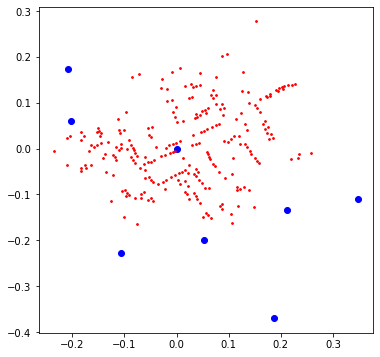

In [497]:
plt.figure(figsize=(6,6))
plt.scatter(pumps.x, pumps.y, color = 'b')
plt.scatter(cholera.x, cholera.y, color = 'r', s=3)


In [498]:
cholera.closest.value_counts()

0    171
1     36
4     19
5     13
7      9
2      2
Name: closest, dtype: int64

#### Note:
So let's look at this. This is a tally of addresses, but we really need the total number of deaths closest to each pump. So we group the data by the column closest, and then sum up the deaths. Okay, so there's no doubt. If deaths occur randomly in each area, there's no way we could get 340 in area zero and so few in all the others.

In [499]:
cholera.groupby('closest').deaths.sum()

closest
0    340
1     65
2      5
4     40
5     27
7     12
Name: deaths, dtype: int64

#### Note:
So to make the game more interesting statistically, we will assume that the populations of each area are very different, with many more people living in the area closest to pump zero. Thus, we do expect more deaths there. So let's make a simulation. We'll use only areas zero, one, four and five, which have the most cases of cholera, and simulate each death randomly, proportionally to the population of each area. I'll write the function for this. Enclose the results in a DataFrame and use numpy random.choice to select a number between zero, one, four and five, n times, with probabilities proportional to populations in the areas. So 65 percent of people in area zero, 15 in area one, and 10 percent each in areas four and five.

In [500]:
def simulate(n):
    return pd.DataFrame({'closest': np.random.choice([0, 1, 4, 5], size=n, p = [0.65, 0.15, 0.10, 0.10])} )

#### Note:
let's try this once for the total number of deaths, which is 489, closest. So we get something close to what we actually observed in the true data

In [501]:
simulate(489).closest.value_counts()

0    322
1     63
5     55
4     49
Name: closest, dtype: int64

#### Note:
let's try this once for the total number of deaths, which is 489, closest. So we get something close to what we actually observed in the true data

In [502]:
sampling = pd.DataFrame({'counts': [simulate(489).closest.value_counts()[0] for i in range(10000)]})

#### Note:
I will look at the histogram. We have generated this distribution under the null hypothesis that the pumps have nothing to do with color, and the deaths occur simply proportionally to population. We can now compare this distribution with the observed number of 340 deaths in area zero. More precisely, we evaluate at what quantile we find 340 in this null hypothesis sampling distribution.

<AxesSubplot:>

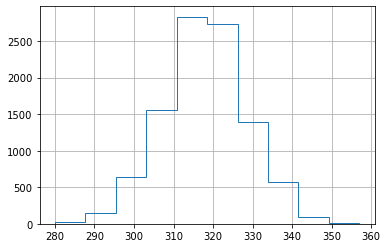

In [503]:
sampling.counts.hist(histtype = 'step')

#### 
Remember, I used scipy.stats.percentileofscore. So 340 is a very extreme value, which we would not expect from the null scenario.

In [504]:
scipy.stats.percentileofscore(sampling.counts,340)

98.32

In [505]:
100-98.14

1.8599999999999994

#### 
In fact, we'd expect it only 1.86 percent of the time. This is known as the P value, the smaller the P value, the more strongly we can reject the null hypothesis. I've just presented a very simple example of hypothesis testing. We have made an observation, many deaths in area zero. We have made a hypothesis it's the pump. And we have estimated the distribution of expected deaths under a null hypothesis. Last, we have verified how extreme our observed finding was with respect to the null distribution. Note that the only two permissible conclusions from a formal hypothesis test such as this is I reject the null hypothesis, or I failed to reject the null hypothesis. This is a very formal way of reasoning, but it's the only one we can support firmly with statistics. The scientific community has recently witnessed a harsh debate about the value of hypothesis testing, and especially about what P value should be required to make a conclusion. The problem is that if you select, say P of 0.05, five percent, but you make many tests, eventually you are going to find many where the null hypothesis is wrongly rejected, just by chance. The lesson is that one must be careful about making conclusions, for instance, by requiring a lower P value or an established causal link, and not just apply a formula blindly.

## Chapter 4.5  p values and confidence intervals
 There is in fact a close relationship between hypothesis testing and confidence intervals. If the null hypothesis corresponds to a range of values for a population parameter that are excluded from the confidence interval, then the null hypothesis must be rejected with a very low P value. The lower, the higher the confidence level of he interval. To exemplify this we go back to our example of the election poll and reformulate it as hypothesis testing.

So we import packages and load the data. To remind you, in the smaller poll Brown had a seeming majority of votes, so here the null hypothesis will be that Green wins or ties the election, so the true Brown fraction would be 0.50 or less. We need to find out whether a Brown proportion of 0.511 is an extreme result if the null hypothesis holds.



In [506]:
poll.vote.value_counts(normalize=True)

Brown    0.511
Green    0.489
Name: vote, dtype: float64

#### Note:
So we compute the sampling distribution of the proportion, and get a true Brown fraction of 0.50. 
If it's lower than that the P value will be even lower. So we can work with 0.50. Here's a
function to simulate the sample of a thousand. Once again, we use numpy random rand and 
compare uniformly distributed numbers between zero and one with the Brown fraction.
Then we use numpy where and return Brown if the condition holds true or Green otherwise.

Finally, we enclose everything in a data frame. 

In [507]:
def sample(brown, n=1000):
    return pd.DataFrame({'vote': np.where(np.random.rand(n) < brown, 'Brown', 'Green')})

#### Note:
Finally, we enclose everything in a data frame. And here's the sampling distribution. We call sample, grab the votes and count them, and then repeat. Collect the results in a list comprehension and then close in the data frame. We forgot one thing in a sample function, which is to return the value. It's an easy fix. This takes a few seconds.And here's the sampling distribution.

In [508]:
dist = pd.DataFrame({'Brown': [sample(0.50, 1000).vote.value_counts(normalize=True)['Brown'] for i in range(10000)]})

Note.

Histogram the sampling distribution, and we see that indeed 0.511 is not a very extreme value. If we look for its quantile we see that the corresponding P value is 24%, certainly not enough to reject the null hypothesis that Green ties or wins. What about the larger sample? Here, it makes sense to set the null hypothesis to Brown winning or tying since Green seems to have the majority. In fact, a nice feature of binary problems, such as this, is that the null hypothesis and its alternative are complementary.

<AxesSubplot:>

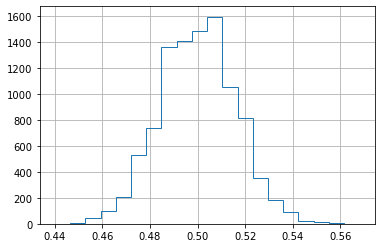

In [510]:
dist.Brown.hist(histtype = 'step', bins=20)

In [511]:
100 - scipy.stats.percentileofscore(dist.Brown, 0.511)

24.409999999999997

#### Note:
So I load the data, look at accounts, and again, compute a sampling distribution at the fraction of 0.50, this time for Green, when the sample's at 10,000. This takes longer, so we compute only 1,000 repetitions. Let's see a histogram. And let's overlay Brown's value of 0.5181. Here, the value's so extreme that it's not even included in our finite sampling distribution. We conclude that the P value for rejecting the null hypothesis that Brown wins or ties is one over 1000 or less, which qualifies as very significant.


In [512]:
largepoll.vote.value_counts(normalize=True)

Green    0.5181
Brown    0.4819
Name: vote, dtype: float64

In [513]:
dist = pd.DataFrame({'Green': [sample(0.50, 10000).vote.value_counts(normalize=True)['Green'] for i in range(10000)]})

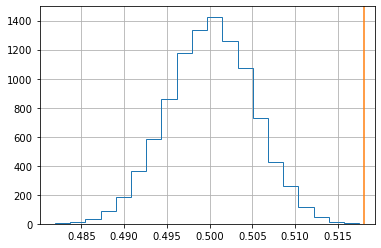

In [514]:
dist.Green.hist(histtype = 'step', bins=20)
plt.axvline(0.5181, c='C1')

#### 
An interesting question is whether one can apply bootstrapping to compute the values. It is all trivial, because bootstrapping can only represent the true distribution, not the distribution under the null hypothesis, so we would need to modify the bootstrap values to be appropriate for the null case, which in some cases is straightforward and not as impossible. Certainly, it requires some thinking and problem specific information. Doing so, is outside the scope of our course.

## Chapter 5: Introduction to Statistical Modeling

###  5.2  Python statistics essential training - fitting models to data

In [3]:
import math
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [4]:
gapminder = pd.read_csv('C:\\Projects\\Data Camp\\Chapter 5 linkedin Statistical modelling\\Ex_Files_Python_Statistics_EssT\\Exercise Files\\chapter5\\05_02\\gapminder.csv')


####  
I have already prepared code to select Gapminder data from year 1985, the year of Live Aid, and to make a scatter plot of child survivor rates versus babies per woman using colors to denote regions and dot sizes to express populations. Let's try it out. (computer keys clicking) We fit models using the very powerful Python package, Statsmodels. We will only scratch the surface of what Statsmodels can do and we will default to its OLS method. OLS stands for ordinary least squares. Least squares means that models are fit by minimizing the sum of square differences between model predictions and observations. Furthermore, ordinary here means that the model coefficients appear lineally in the model formulas. That is, they multiply explanatory variables or functions of explanatory variables. But, do not worry too much about these technical details. What we will do will be very intuitive. Statsmodels lets us specify models by way of the tilde formula notation, which is used also in the statistical language, R. The formulas go like response variable, tilde, model terms. 


In [517]:
gapminder.head()

,country,year,region,population,life_expectancy,age5_surviving,babies_per_woman,gdp_per_capita,gdp_per_day
0,Afghanistan,1800,Asia,3280000.0,28.21,53.142,7.0,603.0,1.650924
1,Afghanistan,1810,Asia,3280000.0,28.11,53.002,7.0,604.0,1.653662
2,Afghanistan,1820,Asia,3323519.0,28.01,52.862,7.0,604.0,1.653662
3,Afghanistan,1830,Asia,3448982.0,27.90,52.719,7.0,625.0,1.711157
4,Afghanistan,1840,Asia,3625022.0,27.80,52.576,7.0,647.0,1.771389


In [16]:
gdata = gapminder.query('year == 1985')
   

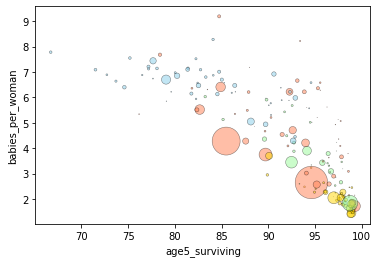

In [519]:
size = 1e-6 * gdata.population

colors = gdata.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral'})

def plotdata():
    gdata.plot.scatter('age5_surviving', 'babies_per_woman', c=colors, s=size, linewidth=0.5, edgecolor='k', alpha=0.5)
    
plotdata()    

#### Note:
I have imported Statsmodels under the alias SMF, so the model is ordinary least squares, and the formula for my first example it just going to be: babies_per_woman ~ 1 representing a constant. I also assigned a data set, g data, to the model.
Next, we need to fit the model. I'm calling this fit grand mean; we'll see in a moment why.
Finally we interrogate the results object. (computer keys clicking) The first thing we can do with it is to use its method to predict, which lets us reproduce model values.

In [520]:
model = smf.ols(formula='babies_per_woman ~ 1', data=gdata)

In [521]:
grandmean = model.fit()

In [522]:
grandmean

#### Note:
We plot them by reproducing colors, but not sizes. Since we'll do this a lot, let me make a function,  which will plot the data first, and then do a scatter plot of one explanatory variable against a model prediction. Let me also set colors, sizes, and a few aesthetic details. One detail I want the function to be generic and so actually plot the prediction for a dummy variable fit. , the result of doing this model is equivalent to returning the mean of our response variables. We can see this by comparing the fit parameters, which are held in the attribute params of the results object with a simple mean of the data.  The constant term is known as intercept.

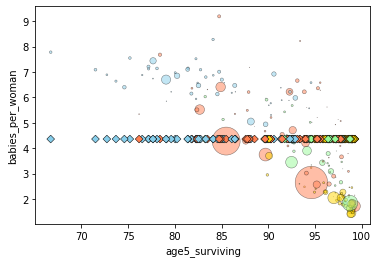

In [523]:
def plotfit(fit):
    plotdata()
    plt.scatter(gdata.age5_surviving, fit.predict(gdata), c=colors, s=30, linewidth=0.5, edgecolor='k', marker = 'D')
    
plotfit(grandmean)

In [524]:
gdata.babies_per_woman.mean()

4.360714285714285

#### Note:
If we now introduce the region as the model term, we get the model equivalent by taking means by group. To add a model term, we include it on the right hand side of the formula with a plus. Let me grab code from above. Add the region, fit directly, and assign the results to a new name. We look at parameters. What we get here is a common constant term, and then offsets four groups minus one of them. 

In [525]:
groupmeans = smf.ols(formula='babies_per_woman ~ 1 + region', data=gdata).fit()

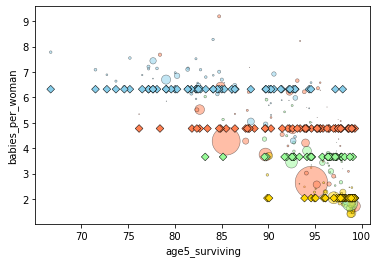

In [526]:
plotfit(groupmeans)

In [527]:
groupmeans.params

Intercept            6.321321
region[T.America]   -2.663139
region[T.Asia]      -1.545744
region[T.Europe]    -4.285639
dtype: float64

#### 
To treat all groups in the same way, we would write a constant with a minus. And again, we can compare with the grouped means

In [528]:
groupmeans = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()

In [529]:
groupmeans.params

region[Africa]     6.321321
region[America]    3.658182
region[Asia]       4.775577
region[Europe]     2.035682
dtype: float64

In [530]:
gdata.groupby('region').babies_per_woman.mean()

region
Africa     6.321321
America    3.658182
Asia       4.775577
Europe     2.035682
Name: babies_per_woman, dtype: float64

#### Note:
Now we try something that we cannot get out of simple means. We add a quantitative variable, child survival, as a main term in the model. We'll call this fit surviving. At least visually, the fit is improving and the fit parameters are interesting.

In [531]:
surviving = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()

In [532]:
surviving.params

region[Africa]     18.265792
region[America]    17.085884
region[Asia]       17.864741
region[Europe]     15.872183
age5_surviving     -0.141886
dtype: float64

#### Note:
The interesting one in particular is age by surviving which is a slope or derivative. It tells us that for every additional percentage point of child survival to age five, the number of babies per woman decreases by .14. Now the constant group terms are large because they theoretically represent the number of children for survivor rate of 0%. If we wish to have a different slope for every region, we can throw in an interaction term, as opposed to a main term, which involves two explanatory variables. We'll call this surviving by region. The interaction term is written with a colon

In [533]:
surviving_byregion = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region', data=gdata).fit()

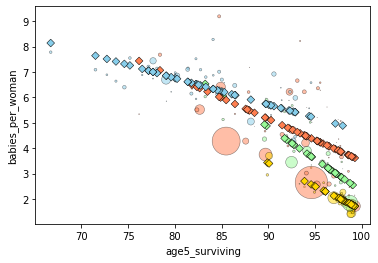

In [534]:
plotfit(surviving_byregion)

In [535]:
surviving_byregion.params

region[Africa]                    15.080914
region[America]                   27.506243
region[Asia]                      20.032483
region[Europe]                    19.884446
age5_surviving:region[Africa]     -0.104053
age5_surviving:region[America]    -0.251994
age5_surviving:region[Asia]       -0.165384
age5_surviving:region[Europe]     -0.183029
dtype: float64

#### 
Now we see that we have four different slopes. India and China, represented by the large circles, seem to be outliers with respect to the fit. Perhaps we can account for them by including another main term this time proportional to population. Let's change the name of the fit again and add the main term. Now we see that the diamonds don't simply lie along straight lines, because of the fact of the population explanatory variable. Well done, we have learned quite a bit. In the next lesson, we see how to tell actually how good any given model is.

In [536]:
surviving_byregion_population = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', data=gdata).fit()

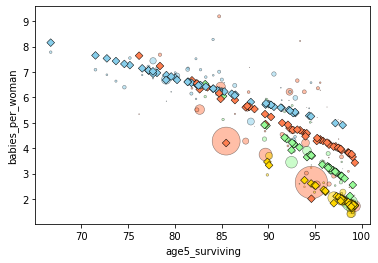

In [537]:
plotfit(surviving_byregion_population)

## 5.3 Goodness of fit

#### Note:
I have copied some code from the last section to load models, set up plotting, and create three linear models. I'll execute all the cells. So here are plots of predictions on top of data for two of the models. Surviving, on top, includes constant terms for every region, plus a single main term, a slope, for age five survival. Surviving population by region includes the constant terms, a different slope for every region, and a main term for population. 

In [242]:
gapminder.head()

,country,year,region,population,life_expectancy,age5_surviving,babies_per_woman,gdp_per_capita,gdp_per_day
0,Afghanistan,1800,Asia,3280000.0,28.21,53.142,7.0,603.0,1.650924
1,Afghanistan,1810,Asia,3280000.0,28.11,53.002,7.0,604.0,1.653662
2,Afghanistan,1820,Asia,3323519.0,28.01,52.862,7.0,604.0,1.653662
3,Afghanistan,1830,Asia,3448982.0,27.90,52.719,7.0,625.0,1.711157
4,Afghanistan,1840,Asia,3625022.0,27.80,52.576,7.0,647.0,1.771389


In [243]:
gdata = gapminder.query('year == 1985')

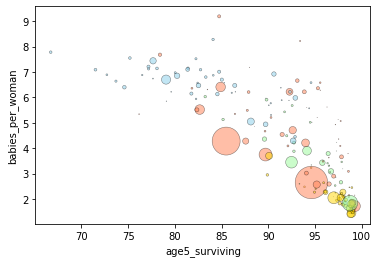

In [244]:
size = 1e-6 * gdata.population

colors = gdata.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral'})

def plotdata():
    gdata.plot.scatter('age5_surviving', 'babies_per_woman', c=colors, s=size, linewidth=0.5, edgecolor='k', alpha=0.5)
    
plotdata() 

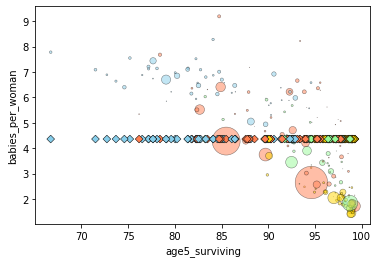

In [245]:
def plotfit(fit):
    plotdata()
    plt.scatter(gdata.age5_surviving, fit.predict(gdata), c=colors, s=30, linewidth=0.5, edgecolor='k', marker = 'D')
    
plotfit(grandmean)

In [246]:
groupmeans = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()

In [247]:
surviving = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()

In [248]:
surviving_byregion_population = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', data=gdata).fit()

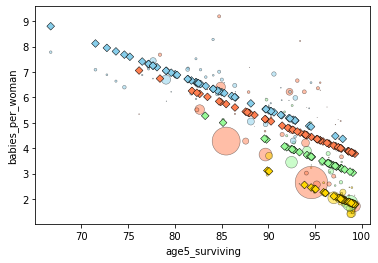

In [249]:
plotfit(surviving)

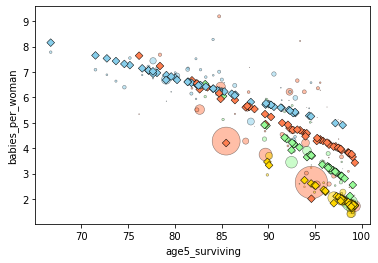

In [250]:
plotfit(surviving_byregion_population)

#####  
How can we tell which model is better? In this section, we will be looking at classical measure of goodness of fit, such as mean square residual, R², the F statistics, and ANOVA tables. All of these and many more have been developed in the analytics-heavy pre-computer era, so they do require some mathematical development to be understood fully. The first thing we can do, though, is to plot the actual residuals. This is saved in the StatsModels fit results object

#### Note;
we can do a scatter plot of an explanatory variable against the residuals. And let's overlay two more. We see that our best model so far, does better than simpler ones, but not by much. The fit results object contain also the mean square residual, which gives us goodness of fit in a single number

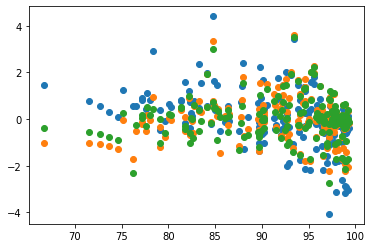

In [251]:
plt.scatter(gdata.age5_surviving, groupmeans.resid)
plt.scatter(gdata.age5_surviving, surviving.resid)
plt.scatter(gdata.age5_surviving, surviving_byregion_population.resid)

#### Note:
So we look over the three models, and just print mse_resid for mean squared error. Mean squared error is the first thing, and the simplest thing I look at. The R² is another statistic that gives us an idea of goodness of fit. It is given by the explained variance, the variance of the fitted model, divided by the total variance of the data. The maximum possible values for the R² is 1, and the minimum is 0. We get it as R² from the result objects.

In [252]:
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.mse_resid)

1.4979520263709154
0.9423025333008321
0.8480227300570319


#### 
In both cases, for mean squared error and R², we see a progress in going towards more complicated models. However, another interesting number that is computed for us by stats models is the F statistic, which takes into account not only the explained and unexplained variance, but the number of model parameters. This shows that too many parameters will overfit the data, conforming to the vagaries of the observations, but losing predictive power. As John von Neumann famously said, "With four parameters, I can fit an elephant, and with five, I can make him wiggle his trunk." So the F statistic measures how much, on average, each parameter contributes to the growth of the R², compared to a random model vector, that is, the hypothetical explanatory variable that has random values, and no link to the response variable at all. An F of 1 means that the parameter contributes the same as a random vector. A large F, that the parameters explains much more than that.

#### Note; 
Again, we get the F statistic from the result objects. These values tell us that the simple surviving model seems to hit a sweet spot. StatsModels actually provides a lot more. 

In [253]:
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.rsquared)

0.636467696559659
0.7726009080146058
0.7999775707885217


In [254]:
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.fvalue)

103.88003937611687
150.3418060343098
86.4878755672519


In [255]:
#  Just look at this summary for a fit.
surviving.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       babies_per_woman   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     150.3
Date:                Sat, 09 Oct 2021   Prob (F-statistic):           8.26e-56
Time:                        14:17:02   Log-Likelihood:                -250.30
No. Observations:                 182   AIC:                             510.6
Df Residuals:                     177   BIC:                             526.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
region[Africa]     18.2658      1.168     15.639      0.000      15.961      20.571
region[America]    17.0859      1.315     12.990      0.000      14.490      19.682
region[Asia]       17.8647      1.279     13.971      0.000      15.341      20.388
region[Europe]     15.8722      1.352     11.739      0.000      13.204      18.541
age5_surviving     -0.1419      0.014    -10.294      0.000      -0.169      -0.115
==============================================================================
Omnibus:                       13.021   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.362
Skew:                           0.443   Prob(JB):                     0.000103
Kurtosis:                       4.279   Cond. No.                     3.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Note:
There are many numbers, statistics, and tests that can be computed for any model. Okay, let me show you one last thing. Certain key goodness of fit statistics are collected in what is known as an ANOVA table, where ANOVA stands for analysis of variance. We get the table from StatsModel stats.anova_lm. Let's see for group means. And again, don't worry about the warning. The first column, the F, shows the number of degrees of freedom, the number of parameters, and for the residual, the number of data points, minus the number of parameters. The sum squared and mean squared columns show the total and average explained in residual variance.

In [256]:
sm.stats.anova_lm(groupmeans)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,655.512121,2.604302e-105
Residual,178.0,266.635461,1.497952,NaN,NaN


####  
We computed those already. The column F is the F statistic, and the last column is the P value for a known model with the same number of parameters as ours, but where all the terms are random. Clearly, the group means region explain a lot of the variance of the data, with a very high F statistic.

#### Note:
We now look at the ANOVA table for the surviving model. Adding the age five surviving variable explains a lot less of the variance, but the F statistic is still pretty high. And for our most complicated model, surviving by region population, we get even lower value for the F statistic for the different parameters, because they are sharing in the interpretation of the data. In the next video, we see a much simpler technique for machine learning to compare different models.

In [257]:
sm.stats.anova_lm(surviving)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1042.049316,8.236854e-122
age5_surviving,1.0,99.847912,99.847912,105.961630,9.003514e-20
Residual,177.0,166.787548,0.942303,NaN,NaN


In [258]:
sm.stats.anova_lm(surviving_byregion_population)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1157.900225,1.132132e-123
age5_surviving:region,4.0,110.113541,27.528385,32.461848,3.514845e-20
population,1.0,9.813987,9.813987,11.572788,8.313090e-04
Residual,173.0,146.707932,0.848023,NaN,NaN


## 5.4 Crossvalidation

#### 
In the last video we saw a few classical analytics have it techniques to have it with goodness of fit, and to compare models based on their explanatory power and simplicity. Now I want to show you how to implement a much simpler strategy known as Cross Validation. Which is used in machine learning to compare models. We divide the data into a training set which we use to feed the model, and a testing set which we use to evaluate the models prediction error. So instead of concentrating on in-sample error as we do with classical techniques, we will look at how to sample prediction error. Models and accounts look better by over fitting the data they're trained on. Instead they need to in some sense understand something about the world. I have all ready included code to load our data set. I import packages. And since we will be splitting our data I have refactored the plotting so it works on arbitrary data. I have also copied the model formulas alone from the last two videos. 

In [380]:
gdata = gapminder.query('year == 1985')

In [381]:
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral'})


def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving', 'babies_per_woman', c=colors, s=size, linewidth=0.5, edgecolor='k', alpha=0.5)
    
def plotfit(fit, data=gdata):
    plotdata(data)
    
    size, colors = sc(data)
    plt.scatter(data.age5_surviving, fit.predict(data), c=colors, s=30, linewidth=0.5, edgecolor='k', marker = 'D')
       
   

In [382]:
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving' '+ age5_surviving:region - age5_surviving + population')

#### Note: 
To divide up our data we first shuffle it with a Panda's data frame method sample. The resulting data search should be the same length as the original. And there is no replacement this time. Then we can use the Panda's locator iloc which goes by row number to divide the rows in two. Enter your division with a double slash and it shows I have a proper index. We now fit the model to the training data. Using one of our formulas. I plot the result. The in-sample in square there is .71. We now tryout the model on the testing data. Plotfit contains a call to stats model predict we generate a moderate response for this particular data set. We see the data points are different, but the fit is comparable. 

In [383]:
shuffled = gdata.sample(len(gdata))

In [384]:
training, testing = shuffled.iloc[:len(gdata) // 2], shuffled.iloc[len(gdata) // 2:]

In [385]:
surviving = smf.ols(f_surviving, data=training).fit()

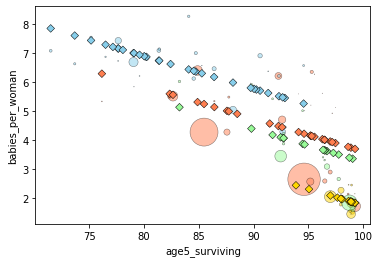

In [386]:
plotfit(surviving, training)

#### Note:
To obtain the mean square there we need to do a little work. We first compute the residuals. May apply modern prediction to the testing data set. We subtract the observe data. Now we compute the number of degrees of freedom, which is the length of the data, minus the number of parameters in the model. Minus one since the number of parameters doesn't count the constant, but we should. Finally, we square up the residuals, sum them, and divide by the number of degrees of freedom. The mean square on the testing data is a little higher since now there's no over fitting. 

In [387]:
resid = surviving.predict(testing) - testing.babies_per_woman
df = len(testing) - surviving.df_model - 1
np.sum(resid ** 2) / df

1.1942426215071775

#### Note:
So let's automate this procedure and use it on the three models. Since the results depend on the shuffling and are rather noisy, we'll repeat a few times and take the average. So I'll make a function that is generic in terms of the formula, of the response variable that we're looking at, and of the number of repititions. We repeat in times. And I'm going to take code from above and modify appropriately. It should let me add one more spot of originality by letting the data be arbitrary. So we shuffle. We divide in two. We train. And we compute the mean square there. We grab an arbitrary response viable column. And finally we collect all these numbers in a Python list. And return its average. Let's try this out. First on the simplest model.

In [388]:
def cross_validate(data, formula, response, n=1000):
    ret = []
    
    for i in range (n):
        shuffled = data.sample(len(data))
        training, testing = shuffled.iloc[:len(data) // 2], shuffled.iloc[len(data) // 2:]
        trained = smf.ols(formula, data=training).fit()
        
        resid = trained.predict(testing) - testing[response]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(resid ** 2) / df
        
        ret.append(mse)
    return np.mean(ret)   

#### Note:
The response variable is always babies per women. On the next model. And on the most complicated one. Cross validation confirms the verdict of analytical goodness of fit measures. The model of intermediate complexity seems to hit the sweet spot in terms of explanatory power. In theory of all data analysts use k fold cross validation instead of dividing the data in two we divide it in k subsets, and then in k successive trials we hold out one of the subsets for testing and trains on all the rest. Finally, the k resulting models are averaged. K fold cross validation is supported in the Python package scikit-learn.

In [389]:
cross_validate(gdata, f_groupmeans, 'babies_per_woman')

1.6550360706895895

In [390]:
cross_validate(gdata, f_surviving, 'babies_per_woman')

1.0565952353123176

In [391]:
cross_validate(gdata, f_srp, 'babies_per_woman')

1.218759141390469

## 5.5 Logistic Regression

#### Note:
How can we perform model fitting when the response variables are categorical? To answer this question, I'll follow the discussion in David Kaplan's "Statistical Modeling." An experiment with the smoking outcomes data set that we used in chapter three. So, I load packages and the data. I have already written a function to plot nicely the data and the fit predictions. And to improve the strength of our conclusions I have removed cases with age greater than 65, none of whom is alive after 20 years. If I convert the smoking outcome to a binary number it becomes possible to do ordinary least squares. We'll try that first. Although, we'll see that there is a much better way.

In [5]:
import math
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

#fix error in some versions of statsmodels

import scipy
if not hasattr(scipy.stats, 'chisqprob'):
    scipy.stats.chisqprob = lambda chisq, df: scipy.stats.chi2.sf(chisq, df)

In [6]:
smoking = pd.read_csv('C:\\Projects\Data Camp\\Chapter 5 linkedin Statistical modelling\\Ex_Files_Python_Statistics_EssT\\Exercise Files\\chapter5\\05_05\\whickham.csv')


In [434]:
smoking.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


In [435]:
smoking = smoking[smoking.age < 65]

In [436]:
color = np.where(smoking.smoker == 'No', 'skyblue', 'coral')
jitter = 0.05*(np.random.rand(len(smoking)) - 0.5)

def plotfit(fit):
    plt.scatter(smoking.age, smoking.outcome + jitter, c=color, linewidth=0.2, edgecolor='k', alpha=0.5)
    plt.scatter(smoking.age, fit.predict(smoking), c=color, linewidth=0.2, edgecolor = 'gray', marker='d')

    

In [437]:
#Here, I can use a Python trick. Multiplying a Boolean by an integer returns an integer

smoking["outcome"] = 1*(smoking["outcome"] == "Alive")

#### Note:
Let's fit a model that includes smoking status and age as main terms. The stats models, ordinary least squares, outcome, tilled, smoker plus age. Data will be the smoking data frame, and we can fit and assign to a variable. Let's see what our plot does.

In [438]:
ols_group_age = smf.ols('outcome ~ smoker + age', data=smoking).fit()

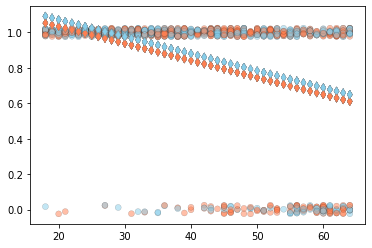

In [439]:
plotfit(ols_group_age)

In [440]:
ols_group_age.params

Intercept        1.264665
smoker[T.Yes]   -0.038738
age             -0.009615
dtype: float64

#### 
The data is plotted as circles, with orange for smokers, and light blue for non-smokers. I have added some jitter, that is, I have moved the points randomly up and down so they don't all lie on top of each other. The fit is represented by the diamonds at the top. We do see there is an association between smoking and negative outcomes. The smoker term is negative.

#### Note:
Let's see the ANOVA table. The association is not especially strong with an F-statistic of eight. You have confirmation of this in the confidence interval the stats models provides for the parameters. Those rely on specific mathematical assumptions about the data, so they should be taken with a grain of salt. The plot, however, shows a mathematical problem.

In [441]:
sm.stats.anova_lm(ols_group_age)

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,0.899981,0.899981,8.181417,4.314608e-03
age,1.0,17.713821,17.713821,161.030213,1.806638e-34
Residual,1068.0,117.483303,0.110003,NaN,NaN


#### Note:
Some predicted outcomes are larger than one. How can we interpret that? What we need is a way to limit the output of the model to values zero and one, or perhaps even better, to values between zero and one that can be understood as the probability of one of the two outcomes. This is done by constructing models in the usual way and then applying a non-linear function to the output. One especially useful non-linear function is the exponential logistic transformation, exp over one plus exp. The process of fitting such a model is called logistic regression. Stat models implements it as logit. I write the same formula for the same data but fit with logit instead of ols. 

In [442]:
ols_group_age.conf_int()

,0,1
Intercept,1.198828,1.330503
smoker[T.Yes],-0.078622,0.001146
age,-0.011102,-0.008129


In [443]:
logit_smoker_age = smf.ols('outcome ~ smoker + age', data=smoking).fit()

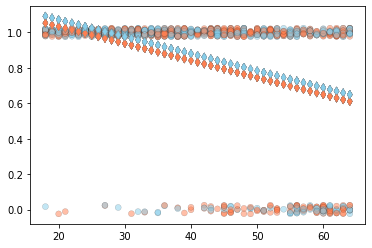

In [444]:
plotfit(logit_smoker_age)

#### 
Let's see a plot. We see now that the model is bounded between zero and one and it displays a non-linear behavior, even if we have all linear main terms. The criteria for logistic regression is not minimizing the mean-square error of the residuals. But rather interpreting the model response as a probability function and maximizing the resulting probability of the observed data. This is a form of maximum-likelihood estimation. So instead of the main square error the simplest way to characterize goodness of fit is the value of the likelihood. Stat models give us its logarithm. Because of the logistic transformation the model parameters are not directly comparable with the least-squares parameters.

In [445]:
logit_smoker_age.llf

-336.20040349762496

In [446]:
logit_smoker_age.params


Intercept        1.264665
smoker[T.Yes]   -0.038738
age             -0.009615
dtype: float64

In [448]:
logit_smoker_age.conf_int()

,0,1
Intercept,1.198828,1.330503
smoker[T.Yes],-0.078622,0.001146
age,-0.011102,-0.008129


In [449]:
logit_smoker_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     84.61
Date:                Sat, 09 Oct 2021   Prob (F-statistic):           7.80e-35
Time:                        16:43:58   Log-Likelihood:                -336.20
No. Observations:                1071   AIC:                             678.4
Df Residuals:                    1068   BIC:                             693.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2647      0.034     37.692      0.000       1.199       1.331
smoker[T.Yes]    -0.0387      0.020     -1.906      0.057      -0.079       0.001
age              -0.0096      0.001    -12.690      0.000      -0.011      -0.008
==============================================================================
Omnibus:                      259.066   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.419
Skew:                          -1.511   Prob(JB):                    9.58e-104
Kurtosis:                       4.222   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

####  
Smoking reduces the probability of being alive, but not uniformly. It does so by .1 at the upper end of the ages, and less for younger subjects. From the confidence intervals we see that the association with smoking remains weak. Stats models can tell us a lot more about this logistic regression fit. But understanding these numbers, this requires some mathematical development. Note that the logistic model probabilities are conditional probabilities. They depend on the value of explanatory variables and they refer directly to the cases in the data set, but not necessarily to the general population. Unless we can determine that the sample is truly representative of the population. The techniques to extrapolate the results from sample to population are beyond the scope of this course. But I encourage to learn more about them.

## 5.6 Bayesian Inference

#### 
Bayesian inference takes a very different viewpoint from anything else we've seen so far. Instead of estimating from the data a single value for the population parameters, we characterize them with entire probability distributions which represent our knowledge and our uncertainty about them. So we start with the prior probability which represents what we already know about the parameters, if anything. We make observations, and we use the observations to update the prior into posterior probability. Here's a silly example. Suppose my cat hid behind one of two doors, I don't know which, so my priors were probability of 50% for each door. If however, I observe the tail, I'm able to update these probabilities to 100% for door one, and 0% for door two. For more general distributions, the update rule is called Bayes' Theorem, and it involves multiplying the prior by the likelihood. The likelihood describes the observations, how likely they are, given a certain value of the parameters. This simple rule is sufficient to generate 90% of Bayesian inference, but the computation may be hard. And in fact, before computers, it was too hard for many statisticians to take Bayesian inference seriously. So what can we do with Python? I'm going to introduce a very powerful package for Bayesian inference, pymc3. Let me load a few packages.

In [7]:
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Note:
I'm going to do a classic Bayesian problem. I have a single coin and I'm suspicious that it's not fair, that is, throwing it repeatedly may return heads between 40% and 80% of the time instead of 50%. So I have thrown the coins 100 times, and I found 61 heads. Now I create my pymc3 model. This is done by setting up a Python context. And then running pymc3 instructions inside a context. p will be the actual fraction that heads comes up for this coin. My prior for it is that it's uniformly distributed between 40% and 80%. Next, my actual observations, the binomial distribution describes the probability of observing k events over n trials if each event has a probability, p, n trials, probability, p, and our observation is k. And finally we sample the posterior, that is, we ask pymc3 to generate a large set of population parameters, which will be approximately distributed according to the posterior. This set of parameters is called a trace. Pymc3 may take a little while to do the sampling, especially the first time.

In [8]:
n = 100
k = 61

with pm.Model() as coin_context:
    p = pm.Uniform('p', 0.40, 0.80)
    
    y = pm.Binomial('y', n=n, p=p, observed=k)
    
    trace = pm.sample(10000)

#Now I can ask it to summarize the posterior for me.
pm.summary(trace)



<ipython-input-8-269003f5df22>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 54 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\archu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.608,0.049,0.515,0.697,0.001,0.0,7814.0,12076.0,1.0


#### 
The mean is 60%, that's the most probable value for the bias-ness of the coin. And the standard deviation is about 5%. The hpd, delimited credible interval, analog to a confidence interval, containing 95% of the probability.

<ipython-input-10-e12e9481f26b>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\archu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

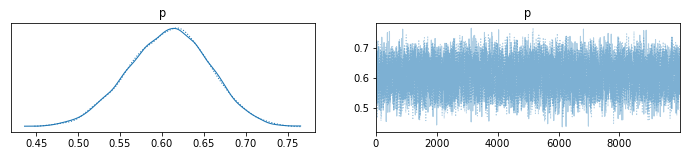

In [10]:
#Pymc3 can also do a nice traceplot.
pm.traceplot(trace)

#### 
There are two curves here, because pymc3 ran two separate sound banks. The plot on the right shows all the values taken on by the parameter, p. Now we move on to Bayesian statistical modeling. 

#### Note:
And once again, we consider the gapminder data for child survival and babies per woman. So I read the dependents and I down-select to year 1985. To plot it better, I will sort the data by age5_surviving value. And let's do a very quick, very simple-minded plot. We've done much better.

In [13]:
gapminder = pd.read_csv('C:\\Projects\\Data Camp\\Chapter 5 linkedin Statistical modelling\\Ex_Files_Python_Statistics_EssT\\Exercise Files\\chapter5\\05_02\\gapminder.csv').query('year == 1985')
gapminder.head()

,country,year,region,population,life_expectancy,age5_surviving,babies_per_woman,gdp_per_capita,gdp_per_day
50,Afghanistan,1985,Asia,11630498.0,45.21,78.400,7.68,1384.0,3.789185
131,Albania,1985,Europe,2966799.0,72.71,94.570,3.23,4267.0,11.682409
212,Algeria,1985,Africa,22565908.0,67.18,92.880,5.98,11030.0,30.198494
293,Angola,1985,Africa,9745209.0,47.50,77.170,7.21,4117.0,11.271732
374,Antigua and Barbuda,1985,America,65744.0,72.13,96.946,2.09,11383.0,31.164956


In [17]:
gdata = gapminder.query('year == 1985')
gdata.sort_values("age5_surviving", inplace=True)

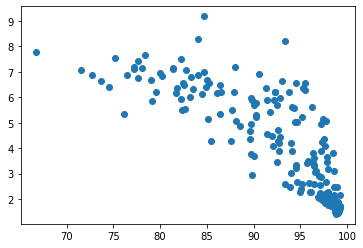

In [18]:
plt.scatter(gdata["age5_surviving"], gdata["babies_per_woman"])

#### Note:
This downward trend is what we'll need to reproduce. So I will put together a very simple model, just a intercept, and a main term, a slope, for age5_surviving. So I open a context and write the priors. For the intercept, I can figure out from the plot, that there should be about 10 where survival is 65%, so I will have a uniform prior between five and 15. For the slope, I can again figure out from the plot, that it should be somewhere around a few tenths. So let's do minus one to one. Next, I define the observations. This will be normally distributed around the model, that is, I allow each data value to have a random measurement error with normal distribution. This is the simplest, most likely hypothesis. Errors are very important in Bayesian inference. The center here, called nu, of the normal distribution, would then be the intercept, plus the slope, times my explanatory variable, which I am referring to 65%. I'll take the standard deviation of the measurement error to be one. And finally, my observation. All done, and I can sample. Don't worry about these messages. Or go look them up in the pymc3 documentation. So here's the summary and the traceplot. The posteriors are centered a little above 10 for the intercept, and close to minus .22 for the slope. We have a very good control over the uncertainty of the parameters. 

In [27]:
with pm.Model() as gapminder_context:
    intercept = pm.Uniform("intercept", 5, 15)
    slope = pm.Uniform("slope", -1, 1)
    
    babies = pm.Normal('babies',
                      mu = intercept + slope * (gdata["age5_surviving"] - 65),
                      sd = 1,
                      observed = gdata["babies_per_woman"])
    trace = pm.sample(10000)

<ipython-input-27-37a77c3b01bc>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\archu\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [slope, intercept]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 1640 seconds.
The acceptance probability does not match the target. It is 0.8858267651431537, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [30]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\archu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,10.193,0.288,9.658,10.727,0.005,0.004,3162.0,3583.0,1.0
slope,-0.219,0.010,-0.239,-0.200,0.000,0.000,3155.0,3557.0,1.0


#### Note:
Evaluated at the mean of the posterior, the model would look like this. I'm taking mean values from the posterior. And now I'll multiply by the explanatory variable. I will plot over the data. And that's our Bayesian fit. In fact, every point in the posterior corresponds to a slightly different model.

<ipython-input-31-4b673fced3da>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\archu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>]], dtype=object)

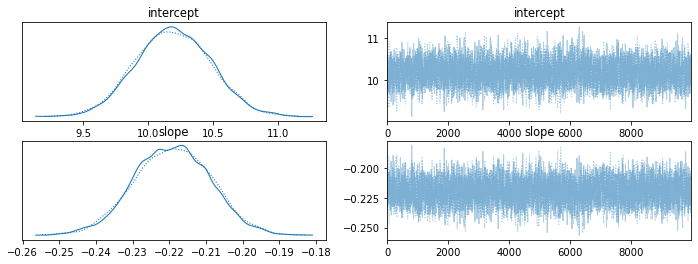

In [31]:
pm.traceplot(trace)

In [32]:
babies = trace["intercept"].mean() + trace["slope"].mean() * (gdata["age5_surviving"] - 65)

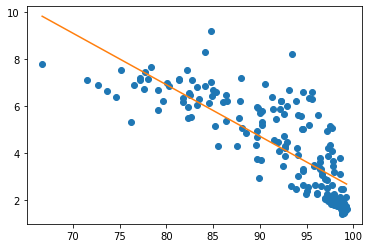

In [33]:
plt.scatter(gdata["age5_surviving"], gdata["babies_per_woman"])
plt.plot(gdata["age5_surviving"], babies, 'C1')

#### Note: 
We can plot them all together to visualize uncertainty. Let me copy some code, the data again, and then I will loop over points in the posterior. Let me do one more thing. Take every 50th point and also stop the iteration after 100 points. I can do that by adding another iterator here, range to 100, and also i to catch it. So then I repeat the calculation of the linear model and plot. Let's give it some transparency. Here is my bundle of models within the posterior. And that's all folks.

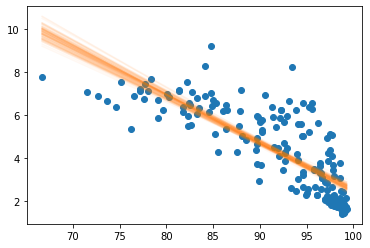

In [34]:
plt.scatter(gdata["age5_surviving"], gdata["babies_per_woman"])

for i, intercept, slope in zip(range(100), trace["intercept"][::50],
                               trace["slope"][::50]):
    babies = intercept + slope * (gdata["age5_surviving"] - 65)
    plt.plot(gdata["age5_surviving"], babies, 'C1', alpha=0.05)

#### Which of the following is correct?
Residuals are differences between model values and observed response variables.


A statistical model is a function of one or more explanatory variables, meant to reproduce a response variable.


####  Which of the following is not correct in the tilde notation used in statsmodels?

"response_var ~ -1 + explanatory_var" for a linear model without a constant term  ; correct answer


"response_var ~ 1" for a grand mean model


"response_var ~ 1:categorical_var" for a group mean model

####  Which of the following is not available in the Results object returned by statmodels

value of the f statistic, as "results.f_value"

ANOVA table, as "results.anova"  correct answer

mean-squared residual, as "results.mse_resid"

best-fit model parameters, as "results.params"

#### What best describes the idea of cross validation?
Compare models by their squared error divided by the number of degrees of freedom.
Compare models by the difference in best-fit model parameters, as computed on subsets of the data.
Compare models by their out-of-sample error, computed over a testing set that was not used to train the models.


####  Logistic regression is used to fit models with binary categorical response variables
Ans: True

####  Which of the following are true for Bayesian model fitting with pymc3?

Observations are typically assimilated using the normal distribution, with mean set to the model (e.g., "intercept + slope * data['x']), and standard deviation set to measurement error.
                                                                                                  
                                                                                                  
Model parameters must be defined with priors, such as "slope = pm.Uniform('slope',-1,1)"
                                                                                                  
                                                                                                  
Posterior distributions for the model parameters are plotted with "pm.traceplot(trace)", with "trace" the object returns by "pm.sample()"
                                                                                                  
                                                                                                  
all of these answers  Correct answer